©Copyright 2022 mafuholic.AllRightsReserved

## Necessary Libraries

In [1]:
import cv2
import time
import os
import numpy as np
import random 
import matplotlib.pyplot as plt
import torch
from torchvision import models, transforms, datasets
import argparse
import torch.nn as nn 
import pandas as pd
import torch.optim as optim

## Utilities
+ **fixRandomSeed** (seed)
    + Fix the random seed, in order to obtain reproducible experiment results
    + Parameters
        + **seed (int)**    -- the random seed

In [2]:
def fixRandomSeed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

+ **transformImage** (img_size)
    + Return a image preprocessor by transforming the image into a torch tensor, with given sizes and values clipped between 0 and 255
    + Parameters
        + **img_size (int)** -- the height/width that is used to resize the original image
    + Return Lists
        + **transform (torchvision.transforms.transforms.Compose)** -- An image preprocessor/transformer

In [3]:
def transformImage (img_size):
    transform = transforms.Compose([
        transforms.Resize(img_size),
        transforms.CenterCrop(img_size),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.mul(255))
    ])
    return transform

+ **computeGram** (tensor)
    + Compute the Gram matrix of the input tensor. Note that here the Gram matrix refers to the linear kernel matrix defined within the tensor. 
    + Parameters
        + **tensor (torch.Tensor)**  -- the input tensor  
    + Return Lists
        + **G (torch.Tensor)** -- the Gram matrix 

In [4]:
def computeGram (tensor):
    # Compute the Gram matrix of the tensor, as well as the linear kernel matrix of the vector
    B, C, H, W = tensor.shape
    v = tensor.view (B, C, H * W)
    v_T = v.transpose (1, 2)
    G = torch.bmm (v, v_T) / (C * H * W)
    return G

+ **loadData** (dataset_dir, img_transform, batch_size)
    + Load the data from the dataset, with given preprocessing strategies and batch size
    + Parameters
        + **dataset_dir (str)**  -- The path/directory for the training dataset (the default dataset is COCO2017-train)
        + **img_transform (torchvision.transforms.transforms.Compose)** -- The image preprocessor that is applied to all images in the dataset
        + **batch_size (int)** -- The size of a batch during the training  
    + Return Lists
        + **data_loader (torch.data.DataLoader)** -- Dataloader 

In [5]:
def loadData (dataset_dir, img_transform, batch_size):
    train_dataset = datasets.ImageFolder(dataset_dir, transform = img_transform)
    data_loader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
    return data_loader

+ **loadImage** (img_path)
    + Load in the image accorrding to the input image path in cv2 form
    + Parameters
        + **img_pth (str)**  -- The path for the image to be read in
    + Return Lists
        + **img (np.array)** -- The image read through cv2  

In [6]:
def loadImage (img_path):
    # Reading images through openCV, and the image in encoded in numpy array
    img = cv2.imread (img_path)   
    return img       

+ **imgToTensor** (img)
    + Transform the cv2 (np array) form into PIL and then into TensorTransform the cv2 (np array) form into PIL and then into Tensor
    + Parameters
        + **img (np.array)**  --  The image in cv2 form
    + Return Lists
        + **tensor (torch.Tensor)** -- The tensor transformed with an extra batch dimension

In [7]:
def imgToTensor (img):
    # Transform the cv2 (np array) form into PIL and then into Tensor
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.mul(255)),
        transforms.Normalize(mean=IMAGENET_MEAN_255, std=IMAGENET_STD_NEUTRAL)
    ])
    tensor = transform(img)

    # Unsqueeze for the batch_size dimension
    tensor = tensor.unsqueeze(dim = 0)
    return tensor


+ **getStyleFeatures** (device, style_img_path, batch_size, VGG)
    + Compute the style representations, and the correlation features as the style features. Note that here, the style image is expanded in consistency with the batch size.
    + Parameters
        + **device (str)**  -- Whether using gpus or a cpu
        + **style_img_path (str)** -- The path for the target style image
        + **batch_size (int)** -- The size of a batch during the training
        + **VGG (nn.Module)** -- The VGG model defined specifically based on the pretained model
    + Return Lists
        + **style_features** -- The style features 

In [8]:
def getStyleFeatures (device, style_img_path, batch_size, VGG):
    # Load the style image
    style_img = loadImage(style_img_path)

    # Transfer the style image into tensor
    style_tensor = imgToTensor(style_img).to(device)

    # Copy the style tensor along the batc_size dimension
    B, C, H, W = style_tensor.shape

    # Compute the style features through a pretrained VGG Network
    style_representation = VGG(style_tensor.expand([batch_size, C, H, W]))

    # Compute the gram matrix 
    style_features = {}
    for key, value in style_representation.items():
        style_features[key] = computeGram(value)
        #print (key)
    return style_features 

+ **computeTrainingLoss** (content_weight, style_weight, content_features, transformed_features, style_features, batch_size, loss)
    + Compue the content loss and style loss respectively and calculate the weighted total loss.
    + Parameters
        + **content_weight (double)**  -- The weight of the content loss
        + **style_weight (double)** -- The weight of the style loss
        + **content_features (dict)** -- The dcitionary with its keys the name of selected content layers and its values the weights of respective layer from the pretrained VGG model
        + **transformed_features (dcit)** -- The dcitionary with its keys the name of selected layers and its values the weights of respective layer from the pretrained VGG model and the transform model
        + **style_features (dcit)** --  The dcitionary with its keys the name of selected style layers and its values the weights of respective layer from the pretrained VGG model
        + **batch_size (int)** -- The size of a batch during the training
        + **loss (torch.nn.loss)** -- The loss function used to compute the losses
    + Return Lists
        + **content_loss (double)** -- The content loss
        + **style_loss (double)** -- The style loss
        + **total_loss (double)** -- The weighted loss

In [9]:
def computeTrainingLoss (content_weight, style_weight, content_features, transformed_features, style_features, batch_size, loss):
    # Compute the content loss with MSE method
    # print (transformed_features['relu2_2'].shape, content_features['relu2_2'].shape)
    content_loss = content_weight * loss (transformed_features['relu2_2'], content_features['relu2_2'])

    # Compute the style loss
    style_loss = 0.0
    for k, v in transformed_features.items():
        #print (style_features)
        tmp = loss (computeGram(v), style_features[k][:batch_size])
        style_loss += tmp
    style_loss *= style_weight

    # Compute the total loss
    total_loss = content_loss + style_loss

    return content_loss, style_loss, total_loss

+ **printLosses** (num_steps, epochs, length, accumulated_content_loss, accumulated_style_loss, accumulated_total_loss, start_time)
    + Print the mean loss history for each iteration after every certain iterations
    + Parameters
        + **num_steps (int)**  -- The number of iterations have been trained
        + **epochs (int)** -- The total epochs set
        + **length (int)** -- The number of iterations required to iterate an epoch
        + **accumulated_content_loss (int)** -- The accumulated loss of the content 
        + **accumulated_style_loss (int)** -- The accumulated loss of the style
        + **start_time (float)** -- The time when the training starts    

In [10]:
def printLosses (num_steps, epochs, length, accumulated_content_loss, accumulated_style_loss, accumulated_total_loss, start_time):
    print(f"========Iteration {num_steps}/{epochs * length}========")
    print(f"\tContent Loss:\t{accumulated_content_loss / num_steps:.2f}")
    print(f"\tStyle Loss:\t{accumulated_style_loss / num_steps:.2f}")
    print(f"\tTotal Loss:\t{accumulated_total_loss / num_steps:.2f}")
    print(f"Time elapsed:\t{time.time() - start_time} seconds")

+ **saveModel** (path, num_step, model)
    + Save the model checkpoints
    + Parameters
        + **path (str)** -- Path for saving models 
        + **num_step (int)** -- The number of iterations have been trained
        + **model (nn.Module)** -- The module need saving

In [11]:
def saveModel (path, num_step, model):
    checkpoint = path + str (num_step) + '.pth'
    torch.save (model.state_dict (), checkpoint)
    print(f"Saved Network checkpoint file at {checkpoint}")

+ **tensorToImg** (tensor)
    + Transform the input tensor into an image
    + Parameters
        + **tensor (torch.Tensor)** -- The input tensor
    + Return Lists
        + **img (numpy.array)** -- The image transformed in np array

In [12]:
def tensorToImg (tensor):
    tensor = tensor.squeeze()
    img = tensor.cpu().numpy()
    img = img.transpose (1, 2, 0)
    return img

+ **saveImg** (img, path)
    + Save the image at the certain path
    + Parameters
        + **img (numpy.array)** -- The input image in np array
        + **path (str)** -- The path for the image to be saved

In [13]:
def saveImg (img, path):
    img = img.clip (0, 255)
    cv2.imwrite (path, img)

+ **saveTrainingSampleImage** (fold, path, num_step)
    + Save the sample image from the training fold to monitor and see through the whole progression 
    + Parameters
        + **fold (torch.Tensor)** -- The current fold generated from the transform network
        + **path (str)** -- The path for the image to be saved
        + **num_step (int)** -- The number of iterations have been trained

In [14]:
def saveTrainingSampleImage (fold, path, num_step):
    sample_tensor = fold[0].clone().detach().unsqueeze (dim = 0)
    sample_img = tensorToImg (sample_tensor.clone().detach())
    sample_path = path + 'sample_' + str (num_step) + '.jpg'
    saveImg (sample_img, sample_path)
    print(f"Saved sample tranformed image at {sample_path}")

+ **printSummary** (network_name, start_time, stop_time, content_loss_history, style_loss_history, total_loss_history)
    + Print the whole training losses history 
    + Parameters
        + **network_name (str)** -- The name of the network model 
        + **start_time (float)** -- The time when the training starts
        + **stop_time (float)** -- The time when the whole training ends
        + **content_loss_history (list)** -- The history list of content losses
        + **style_loss_history (list)** -- The history list of style losses
        + **total_loss_history (list)** -- The history list of total losses

In [15]:
def printSummary (network_name, start_time, stop_time, content_loss_history, style_loss_history, total_loss_history):
    print("Done Training the "+ network_name + " Network!")
    print(f"Training Time Costs: {stop_time - start_time} seconds")
    print("========Content Loss========")
    print(list(content_loss_history))
    print("========Style Loss========")
    print(list(style_loss_history))
    print("========Total Loss========")
    print(list(total_loss_history))

+ **saveTransformModel** (model, path)
    + Save the final transform model at the given path
    + Parameters
        + **model (nn.Module)** -- The final transform model 
        + **path  (str)** -- The path for the final model weight file

In [16]:
def saveTransformModel (model, path):
    model.eval()
    model.cpu()
    path = os.path.join ('./transform_weight', path + '.pth')
    print(f"Saving TransformerNetwork weight at {path}")
    torch.save(model.state_dict(), path)
    print("Done saving final model")

+ **show** (img)
    + Show the img with the matplotlib.show()
    + Parameters
        + **img (numpy.array)** -- The input image

In [17]:
def show(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = np.array(img / 255).clip(0, 1)
    plt.figure(figsize = (10, 5))
    plt.imshow(img)
    plt.show()

+ **saveLossAsCsv** (content_loss_history, style_loss_history, total_loss_history)
    + Save the loss histories at certain path
    + Parameters
        + **content_loss_history (list)** -- The history list of content losses
        + **style_loss_history (list)** -- The history list of style losses
        + **total_loss_history (list)** -- The history list of total losses

In [18]:
def saveLossAsCsv (content_loss_history, style_loss_history, total_loss_history):
    for index in range (len (content_loss_history)):
        content_loss_history[index] = content_loss_history[index].cpu().detach().numpy()
        style_loss_history[index] = style_loss_history[index].cpu().detach().numpy()
        total_loss_history[index] = total_loss_history[index].cpu().detach().numpy()
    ct_loss = pd.DataFrame ({'loss' : content_loss_history})
    st_loss = pd.DataFrame ({'loss' : style_loss_history})
    tt_loss = pd.DataFrame ({'loss' : total_loss_history})
    ct_loss.to_csv ('./losses/ct_loss.csv')
    st_loss.to_csv ('./losses/st_loss.csv')
    tt_loss.to_csv ('./losses/tt_loss.csv')

## Configurations (Args)

In [19]:
import argparse
config = argparse.ArgumentParser (description = 'Style Trasfer')
config.add_argument ('--epochs', type = int, default = 1, help = 'Number of iterations for training the transformer model')
config.add_argument ('--gpu_id', type = str, default = '0', help = 'GPU No. if multiplt gpus have been used else 0')
config.add_argument ('--img_size', type = int, default = 256, help = 'Image size on the training stage')
config.add_argument ('--seed', type = int, default = 1, help = 'Random Seed')
config.add_argument ('--dataset_dir', type = str, default = './images/content_images', help = 'Path for datasets for training')
config.add_argument ('--batch_size', type = int, default = 4, help = 'The batch size for training')
config.add_argument ('--learning_rate', type = float, default = 1e-3, help = 'Learning rate for the optimizer')
config.add_argument ('--style_img_path', type = str, default = './images/style_images/mosaic.jpg', help = 'The style image')
config.add_argument ('--content_weight', type = float, default = 5, help = 'The weight of content loss when compting the total loss')
config.add_argument ('--style_weight', type = float, default = 5, help = 'The weight of style loss when compting the total loss')
config.add_argument ('--interval', type = int, default = 2, help = 'Save and show the model after every interval times')
config.add_argument ('--save_model_path', type = str, default = './weights/', help = 'Path for the model saved')
config.add_argument ('--save_img_path', type = str, default = './images/results/', help = 'Path for saving the sample images and result images')
config.add_argument ('--transform_model_path', type = str, default = 'transform', help = 'Path for the saving the transform model')

_StoreAction(option_strings=['--transform_model_path'], dest='transform_model_path', nargs=None, const=None, default='transform', type=<class 'str'>, choices=None, help='Path for the saving the transform model', metavar=None)

In [20]:
# args = config.parse_args (args = [])

## Train
+ **train** (args)
    + Train the transform network on each style image with certain configuration of arguments
    + Parameters
        + **args (argparse.Namespace)** -- arguments passed to the train function
        

In [21]:
def train (args):
    # Device setting
    device = ("cuda" if torch.cuda.is_available() else "cpu")

    # Multi-threads setting
    os.environ["CUDA_VISIBLE_DEVICES"] = args.gpu_id

    # Fix the random seed
    fixRandomSeed(args.seed)

    # Generate the dataset and the dataloader
    
    transform = transformImage (args.img_size)
    data_loader = loadData (args.dataset_dir, transform, args.batch_size)

    # Define Neural Networks
    VGG = vgg16_pretrained().to(device)
    TransformNN = TransformNet().to(device)

    # Define the optimizer
    optimizer = optim.Adam (TransformNN.parameters(), lr = args.learning_rate)

    # Define loss function
    loss = nn.MSELoss().to(device)

    # Obtain style representations/features
    style_features = getStyleFeatures (device, args.style_img_path, args.batch_size, VGG)

    # Initalizing Loss Histories
    content_loss_history = []
    style_loss_history = []
    total_loss_history = []
    accumulated_content_loss = 0
    accumulated_style_loss = 0
    accumulated_total_loss = 0

    # Optimization/Training Loop
    num_step = 0
    start_time = time.time()

    # Training
    for epoch in range (args.epochs):
        for fold, _ in data_loader:
            num_step += 1
            batch_size = fold.shape[0]

            # Free the unimportant tensors to release the GPU memory
            torch.cuda.empty_cache()

            # Zero_out Gradients
            optimizer.zero_grad()

            # Compute the transformed batch/fold formed by the transform net
            fold = fold[:, [2, 1, 0]].to (device)
            transformed_fold = TransformNN (fold)
            fold_n = transforms.Normalize(mean=IMAGENET_MEAN_255, std=IMAGENET_STD_NEUTRAL)(fold)
            transformed_fold_n = transforms.Normalize(mean=IMAGENET_MEAN_255, std=IMAGENET_STD_NEUTRAL)(transformed_fold)

            # Compute the features generated by the pretrained VGG networks and the transform network
            content_features = VGG (fold_n)
            transformed_features = VGG (transformed_fold_n)

            # Compute the losses
            content_loss, style_loss, total_loss = computeTrainingLoss (args.content_weight, args.style_weight, content_features, transformed_features, style_features, batch_size, loss)

            # Record the training history & accumulated loss
            accumulated_content_loss += content_loss
            accumulated_style_loss += style_loss
            accumulated_total_loss += total_loss

            # Back propagation
            total_loss.backward()
            optimizer.step()

            # Show the training history
            if (num_step + 1) % args.interval == 0:
                # Print the loss 
                printLosses (num_step, args.epochs, len(data_loader), accumulated_content_loss, accumulated_style_loss, accumulated_total_loss, start_time)

                # Save the model
                saveModel (args.save_model_path, num_step, TransformNN)

                # Save the sample image from the training stage.
                saveTrainingSampleImage (transformed_fold, args.save_img_path, num_step)

                # Record the loss history
                content_loss_history.append(accumulated_total_loss / num_step)
                style_loss_history.append(accumulated_style_loss / num_step)
                total_loss_history.append(accumulated_total_loss / num_step)

                # Clear the accumulated loss 
                accumulated_content_loss = 0
                accumulated_style_loss = 0
                accumulated_total_loss = 0
    stop_time = time.time()

    # Save the summary of the whole training process
    printSummary ("Transform", start_time, stop_time, content_loss_history, style_loss_history, total_loss_history)

    # Save the losses function 
    saveLossAsCsv (content_loss_history, style_loss_history, total_loss_history)
    
    # Save the TransformerNetwork model
    saveTransformModel (TransformNN, args.transform_model_path)

## Models
### VGG-16

In [22]:
class vgg16(nn.Module):
    def __init__(self, weight_path = './weights/vgg16.pth'):
        super(vgg16, self).__init__()
        model = models.vgg16(pretrained = False)
        model.load_state_dict(torch.load(weight_path), strict = False)
        self.features = model.features

    def forward(self, x):
        feature_extract = {
            '3' : 'relu1_2',
            '8' : 'relu2_2',
            '15' : 'relu3_3',
            '22' : 'relu4_3'
        }
        out_features = {}
        for name, layer in self.features._modules.items():
            x = layer(x)
            if name in feature_extract:
                out_features[feature_extract[name]] = x
                if name == '22':
                    break
        return out_features


def vgg16_pretrained(weight_path = './weights/vgg16.pth'):
    model = vgg16(weight_path)

    # Fixed the pretrained loss network in order to define our loss functions
    for param in model.parameters():
        param.requires_grad = False
    return model

### TransformNet 

In [38]:
class TransformNet(nn.Module):
    def __init__(self):
        super(TransformNet, self).__init__()
        self.ConvBlocks = nn.Sequential(
            ConvBlock(3, 32, 9, 1),
            nn.ReLU(),
            ConvBlock(32, 64, 3, 2),
            nn.ReLU(),
            ConvBlock(64, 128, 3, 2),
            nn.ReLU()
        )
        self.ResidualBlocks = nn.Sequential(
            ResidualBlock(128, 3),
            ResidualBlock(128, 3),
            ResidualBlock(128, 3),
            ResidualBlock(128, 3),
            ResidualBlock(128, 3)
        )
        self.UpSamplingBlocks = nn.Sequential(
            UpSamplingBlock(128, 64, 3, 2, 1),
            nn.ReLU(),
            UpSamplingBlock(64, 32, 3, 2, 1),
            nn.ReLU(),
            ConvBlock(32, 3, 9, 1, norm = "None")
        )

    def forward(self, x):
        x = self.ConvBlocks(x)
        x = self.ResidualBlocks(x)
        out = self.UpSamplingBlocks(x)
        return out


class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, norm = "instance"):
        super(ConvBlock, self).__init__()
        padding_size = kernel_size // 2
        self.reflection_pad = nn.ReflectionPad2d(padding_size)

        self.conv_layer = nn.Conv2d(in_channels, out_channels, kernel_size, stride)

        # Normalization Layers
        self.norm_type = norm
        if norm == "instance":
            self.norm_layer = nn.InstanceNorm2d(out_channels, affine = True)
        elif norm == "batch":
            self.norm_layer = nn.BatchNorm2d(out_channels, affine = True)

    def forward(self, x):
        x = self.reflection_pad(x)
        x = self.conv_layer(x)
        if self.norm_type == "None":
            out = x
        else:
            out = self.norm_layer(x)
        return out

class ResidualBlock(nn.Module):
    def __init__(self, channels = 128, kernel_size = 3):
        super(ResidualBlock, self).__init__()
        self.conv1 = ConvBlock(channels, channels, kernel_size, stride = 1)
        self.in1 = nn.InstanceNorm2d(channels, affine=True)
        self.relu = nn.ReLU()
        self.conv2 = ConvBlock(channels, channels, kernel_size, stride = 1)
        self.in2 = nn.InstanceNorm2d(channels, affine=True)

    def forward(self, x):
        residual = x
        out = self.relu(self.in1(self.conv1(x)))
        out = self.in2(self.conv2(out))
        out = out + residual
        out = self.relu(out)
        return out 

class UpSamplingBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, output_padding, norm="instance"):
        super(UpSamplingBlock, self).__init__()

        # Transposed Convolution
        padding_size = kernel_size // 2
        self.conv_transpose = nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding_size, output_padding)

        # Normalization Layers
        self.norm_type = norm
        if (norm == "instance"):
            self.norm_layer = nn.InstanceNorm2d(out_channels, affine = True)
        elif (norm == "batch"):
            self.norm_layer = nn.BatchNorm2d(out_channels, affine = True)

    def forward(self, x):
        x = self.conv_transpose(x)
        if self.norm_type == "None":
            out = x
        else:
            out = self.norm_layer(x)
        return out

## Miscellanea (Constants)

In [24]:
IMAGENET_MEAN_255 = [103.53, 116.28, 123.675]
IMAGENET_STD_NEUTRAL = [1, 1, 1]

os.makedirs ('./weights', exist_ok = True)
os.makedirs ('./transform_weight', exist_ok = True)

## Style Transfer
+ **style_transfer** (content_img_path, STYLE_TRANSFORM_PATH)
    + Perform the style transferring with certain contant image and style image
    + Parameters
        + **content_img_path (str)** -- Path for the content image
        + **STYLE_TRANSFORM_PATH (str)** -- Path for the TransformNet weights w.r.t. certain style image

In [31]:
def style_transfer(content_img_path, STYLE_TRANSFORM_PATH):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    inference_device = "GPU" if device == "cuda" else "CPU"

    net = TransformNet()
    with torch.no_grad():
        content_image = loadImage(content_img_path)
        start_time = time.time()
        content_tensor = imgToTensor(content_image).to(device)
        net.load_state_dict(torch.load(STYLE_TRANSFORM_PATH, map_location='cpu'))
        net = net.to(device)
        start_time = time.time()
        content_tensor = imgToTensor(content_image).to(device)
        generated_tensor = net(content_tensor)
        generated_image = tensorToImg(generated_tensor.detach())
        save_path = './images/tmp/6_' + content_img_path.split('/')[-1]
        saveImg (generated_image, save_path)
        print("Transfer Time: {}".format(time.time() - start_time))
        show(generated_image)

## Example

In [248]:
args = config.parse_args (args = ['--interval=1', '--epoch=2', '--batch_size=4', '--dataset_dir=./images/content_images'])
train (args)

========Iteration 1/4========
	Content Loss:	2565155.00
	Style Loss:	19020872.00
	Total Loss:	21586028.00
Time elapsed:	0.2449054718017578 seconds
Saved Network checkpoint file at ./weights/1.pth
Saved sample tranformed image at ./images/results/sample_1.jpg
========Iteration 2/4========
	Content Loss:	828809.00
	Style Loss:	9487440.00
	Total Loss:	10316249.00
Time elapsed:	0.38373351097106934 seconds
Saved Network checkpoint file at ./weights/2.pth
Saved sample tranformed image at ./images/results/sample_2.jpg
========Iteration 3/4========
	Content Loss:	617246.56
	Style Loss:	6294878.50
	Total Loss:	6912125.50
Time elapsed:	0.5666890144348145 seconds
Saved Network checkpoint file at ./weights/3.pth
Saved sample tranformed image at ./images/results/sample_3.jpg
========Iteration 4/4========
	Content Loss:	752133.88
	Style Loss:	4708379.00
	Total Loss:	5460513.00
Time elapsed:	0.7502846717834473 seconds
Saved Network checkpoint file at ./weights/4.pth
Saved sample tranformed image at .

Transfer Time: 4.66816520690918


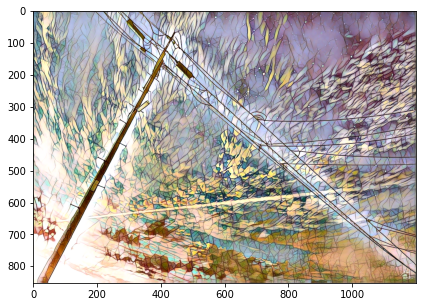

In [44]:
style_transfer ('./images/input_images/sunset.jpg', './transform_weight/mosaic.pth')

## TransformNet (Without Instance Normalization)

In [42]:
class TransformNet(nn.Module):
    def __init__(self):
        super(TransformNet, self).__init__()
        self.ConvBlock = nn.Sequential(
            ConvLayer(3, 32, 9, 1),
            nn.ReLU(),
            ConvLayer(32, 64, 3, 2),
            nn.ReLU(),
            ConvLayer(64, 128, 3, 2),
            nn.ReLU()
        )
        self.ResidualBlock = nn.Sequential(
            ResidualLayer(128, 3),
            ResidualLayer(128, 3),
            ResidualLayer(128, 3),
            ResidualLayer(128, 3),
            ResidualLayer(128, 3)
        )
        self.DeconvBlock = nn.Sequential(
            DeconvLayer(128, 64, 3, 2, 1),
            nn.ReLU(),
            DeconvLayer(64, 32, 3, 2, 1),
            nn.ReLU(),
            ConvLayer(32, 3, 9, 1, norm = "None")
        )

    def forward(self, x):
        x = self.ConvBlock(x)
        x = self.ResidualBlock(x)
        out = self.DeconvBlock(x)
        return out


class ConvLayer(nn.Module):
    def __init__(self, in_dim, out_dim, kernel_size, stride, norm = "instance"):
        super(ConvLayer, self).__init__()
        padding_size = kernel_size // 2
        self.reflection_pad = nn.ReflectionPad2d(padding_size)

        self.conv_layer = nn.Conv2d(in_dim, out_dim, kernel_size, stride)

        # Normalization Layers
        self.norm_type = norm
        if norm == "instance":
            self.norm_layer = nn.InstanceNorm2d(out_dim, affine = True)
        elif norm == "batch":
            self.norm_layer = nn.BatchNorm2d(out_dim, affine = True)

    def forward(self, x):
        x = self.reflection_pad(x)
        x = self.conv_layer(x)
        if self.norm_type == "None":
            out = x
        else:
            out = self.norm_layer(x)
        return out

class ResidualLayer(nn.Module):
    def __init__(self, channels = 128, kernel_size = 3):
        super(ResidualLayer, self).__init__()
        self.conv1 = ConvLayer(channels, channels, kernel_size, stride = 1)
        self.relu = nn.ReLU()
        self.conv2 = ConvLayer(channels, channels, kernel_size, stride = 1)

    def forward(self, x):
        identity = x
        out = self.relu(self.conv1(x))
        out = self.conv2(out)
        out = out + identity
        return out

class DeconvLayer(nn.Module):
    def __init__(self, in_dim, out_dim, kernel_size, stride, output_padding, norm="instance"):
        super(DeconvLayer, self).__init__()

        # Transposed Convolution
        padding_size = kernel_size // 2
        self.conv_transpose = nn.ConvTranspose2d(in_dim, out_dim, kernel_size, stride, padding_size, output_padding)

        # Normalization Layers
        self.norm_type = norm
        if (norm == "instance"):
            self.norm_layer = nn.InstanceNorm2d(out_dim, affine = True)
        elif (norm == "batch"):
            self.norm_layer = nn.BatchNorm2d(out_dim, affine = True)

    def forward(self, x):
        x = self.conv_transpose(x)
        if self.norm_type == "None":
            out = x
        else:
            out = self.norm_layer(x)
        return out